# 数据可视化

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch


df_reviewer = pd.read_csv(".data/df_reviewer.csv")
df_author_response=pd.read_csv(".data/df_author_response.csv")
gender_df2=pd.read_csv(".data/gender2.csv")
grouped_gender_first = pd.read_csv(".data/grouped_gender_first.csv")
grouped_gender_last = pd.read_csv(".data/grouped_gender_last.csv")
df_words = pd.read_csv(".data/df_words.csv")

valid_gender=['male','female']

/home/dell/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,11,15,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 1.同行评议过程中的情感互动呈现出怎样的动态特征?

## 1.1.评审意见和作者回复的情感极性变化

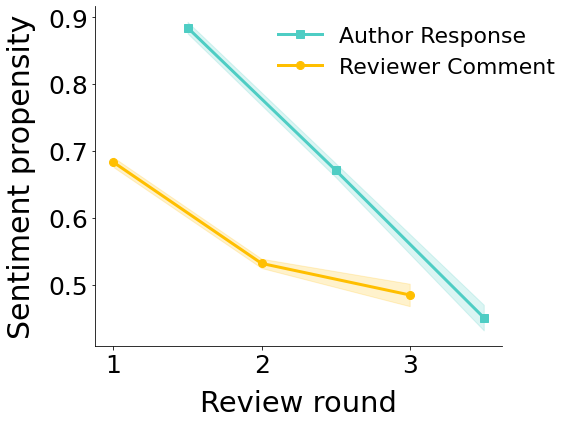

In [2]:
character_colors={"author": "#4ECDC4","reviewer": "#FFBF00"}

# ========== Compound 图准备 ==========
# 作者
author_compound_cols = [f'Round_{i}_response_compound' for i in range(1, 6)]
df_author_compound = df_author_response.melt(id_vars=['PaperId'],value_vars=author_compound_cols,var_name='Round',value_name='Compound')
df_author_compound['Round'] = df_author_compound['Round'].str.extract(r'Round_(\d+)_response').astype(int)
df_author_compound = df_author_compound.dropna(subset=['Compound'])
author_compound_summary = df_author_compound.groupby('Round')['Compound'].agg(['mean', 'count', 'std']).reset_index()
author_compound_summary['ci95'] = 1.96 * author_compound_summary['std'] / np.sqrt(author_compound_summary['count'])
author_compound_summary = author_compound_summary[author_compound_summary['Round']<=3]
# 评审专家
compound_cols = [f'Round_{i}_compound' for i in range(1, 6)]
df_compound = df_reviewer.melt(id_vars=['PaperId', 'Reviewer_ID'],value_vars=compound_cols,var_name='Round',value_name='Compound')
df_compound['Round'] = df_compound['Round'].str.extract(r'Round_(\d+)').astype(int)
df_compound = df_compound.dropna(subset=['Compound'])
df_compound=df_compound[df_compound['Compound']!='unknown'].copy()
df_compound['Compound']=df_compound['Compound'].astype(float)
compound_summary = df_compound.groupby('Round')['Compound'].agg(['mean', 'count', 'std']).reset_index()
compound_summary['ci95'] = 1.96 * compound_summary['std'] / np.sqrt(compound_summary['count'])
compound_summary = compound_summary[compound_summary['Round']<=3]

# ========== 绘图 ==========
plt.figure(figsize=(7.8, 6))  # Adjust figure size as needed

# Plot author compound scores
plt.plot(author_compound_summary['Round']+0.5, author_compound_summary['mean'], marker='s', color=character_colors['author'], label="Author Response",linewidth=3.0,markersize=8)
plt.fill_between(author_compound_summary['Round']+0.5,author_compound_summary['mean'] - author_compound_summary['ci95'],author_compound_summary['mean'] + author_compound_summary['ci95'],color=character_colors['author'], alpha=0.2)

# Plot reviewer compound scores
plt.plot(compound_summary['Round'], compound_summary['mean'], marker='o', color=character_colors['reviewer'], label="Reviewer Comment",linewidth=3.0,markersize=8)
plt.fill_between(compound_summary['Round'],compound_summary['mean'] - compound_summary['ci95'],compound_summary['mean'] + compound_summary['ci95'],color=character_colors['reviewer'], alpha=0.2)

# Set labels and title
plt.xlabel('Review round', fontsize=29,labelpad=12)
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.ylabel('Sentiment propensity', fontsize=30,labelpad=12)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)
plt.legend(fontsize=22,bbox_to_anchor=(0.4, 1),frameon=False)

plt.tight_layout()
plt.show()

## 1.2.情感关键词分布和代表关键词

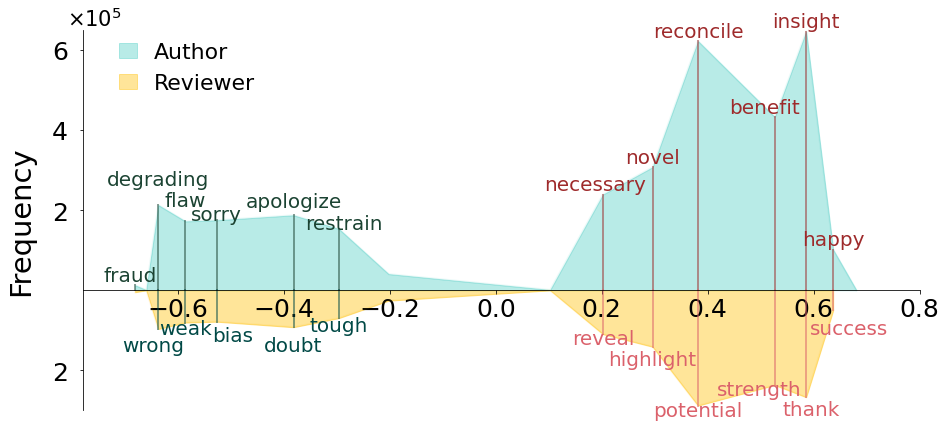

In [3]:
plt.figure(figsize=(15, 7))

# 处理 author 数据
author_data = df_words[df_words['Role'] == 'author']
sentiment_words_author = author_data.groupby('compound')['frequency'].sum()
sentiment_words_author_smoothed = sentiment_words_author.rolling(window=1).mean()

# 绘制 author 数据的情感极性曲线
plt.fill_between(sentiment_words_author.index.values,0,sentiment_words_author_smoothed.values,color=character_colors['author'],alpha=0.4,label='Author')
plt.plot(sentiment_words_author.index,sentiment_words_author_smoothed,color=character_colors['author'],alpha=0.1,linewidth=2)

# 处理 reviewer 数据
reviewer_data = df_words[df_words['Role'] == 'reviewer']
sentiment_words_reviewer = reviewer_data.groupby('compound')['frequency'].sum()
sentiment_words_reviewer_smoothed = sentiment_words_reviewer.rolling(window=1).mean()

# 绘制 reviewer 数据的情感极性曲线（向下延伸）
plt.fill_between(sentiment_words_reviewer.index.values,0,-sentiment_words_reviewer_smoothed.values,color=character_colors['reviewer'],alpha=0.4,label='Reviewer')
plt.plot(sentiment_words_reviewer.index,-sentiment_words_reviewer_smoothed,color=character_colors['reviewer'],alpha=0.1,linewidth=2)

# 设置标题和标签
plt.text(-0.81, 650000.02,r'$\times 10^5$', fontsize=21,va='bottom',ha='left')

yticks_labels = [2,2,4,6]

plt.yticks(ticks=[-200000,200000, 400000, 600000], labels=yticks_labels, fontsize=25)
ax = plt.gca()
ax.tick_params(axis='y', pad=11) 
plt.ylabel('Frequency', fontsize=29, labelpad=17)

# 隐藏右上边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 设置 y 轴范围
plt.ylim([-300000, 650000])  
plt.xlim([-0.78, 0.8])

# 将x轴移动到y=0的位置
ax = plt.gca()
ax.spines['bottom'].set_position('zero')  # 关键步骤：移动x轴
ax.xaxis.set_ticks_position('bottom')    # 确保刻度在x轴上
plt.xticks(fontsize=25,rotation=0, ha='center')      # 调整刻度标签

# 添加图例
plt.legend(bbox_to_anchor=(0.23, 1.02),fontsize=22,title_fontsize=24,frameon=False,handlelength=0.8)

    
# 作者top词
author_words = {
    'fraud': [-0.6808, 12262.0, -0.6908, 12262.0],'degrading': [-0.6369, 212310.0, -0.6369, 252310.0],
    'flaw': [-0.5859, 171779.0, -0.5859, 199779.0],'sorry': [-0.5267, 174539.0, -0.5267, 164539.0],
    'apologize': [-0.3818, 187009.0, -0.3818, 197009.0],'restrain': [-0.2960, 152671.0, -0.2860, 142671.0],
    'necessary': [0.2023, 238742.0, 0.188, 238742.0],'novel': [0.2960, 306909.0, 0.2960, 306909.0],
    'reconcile': [0.3818, 621801.0, 0.3818, 621801.0],'benefit': [0.5267, 432119.0, 0.5067, 432119.0],
    'insight': [0.5859, 645526.0, 0.5859, 645526.0],'happy': [0.6369, 101120.0, 0.6369, 101120.0]}

for word in author_words.keys():
    com_x,freq_y,label_x,label_y = author_words[word][0],author_words[word][1],author_words[word][2],author_words[word][3]
    line_color = '#9E2A2B' if com_x > 0 else '#1B4332'
    plt.plot([com_x, com_x], [0, freq_y], color=line_color, linewidth=2, alpha=0.5)
    # 添加单词标签（旋转0度，放在竖线上方）
    plt.text(x=label_x, y=label_y+1000, s=word, rotation=0, ha='center', va='bottom', fontsize=20, color=line_color)


# # 评审top词
reviewer_words = {
    'wrong': [-0.6369, 96906.0, -0.6469, -125906.0],
    'weak': [-0.5859, 80844.0, -0.5849, -82844.0],
    'bias': [-0.5267, 78650.0, -0.4967, -100650.0],
    'doubt': [-0.3818, 92403.0, -0.3818, -125403.0],
    'tough': [-0.2960, 69659.0, -0.2960, -77659.0],
    'reveal': [0.2023, 109741.0, 0.2023, -109741.0],
    'highlight': [0.2960, 141180.0, 0.2960, -161180.0],
    'potential': [0.3818, 288072.0, 0.3818, -288072.0],
    'thank': [0.5859, 267158.0, 0.5959, -287158.0],
    'strength': [0.5267, 236789.0, 0.4967, -236789.0],
    'success': [0.6369, 50647.0, 0.6669, -84647.0]
}

for word in reviewer_words.keys():
    com_x,freq_y,label_x,label_y = reviewer_words[word][0],reviewer_words[word][1],reviewer_words[word][2],reviewer_words[word][3]
    line_color = '#db616b' if com_x > 0 else '#014946'
    plt.plot([com_x, com_x], [0, -freq_y], color=line_color, linewidth=2, alpha=0.5)
    # 添加单词标签（旋转0度，放在竖线上方）
    plt.text(x=label_x, y=label_y-35500, s=word, rotation=0, ha='center', va='bottom', fontsize=20, color=line_color)

plt.grid(False)
plt.show()


## 1.3.情感倾向随时间的变化

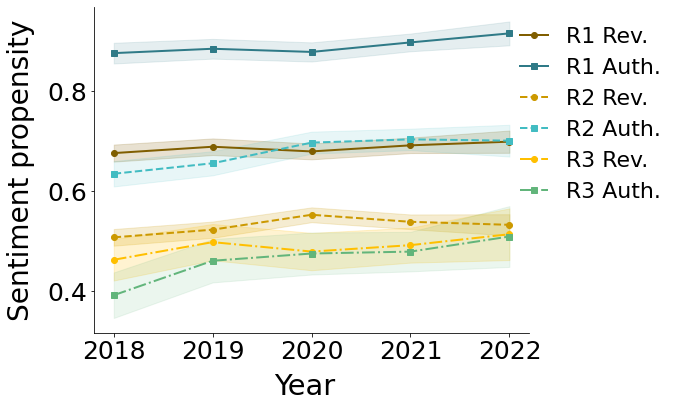

In [4]:
# ========== Reviewer Sentiment Data (Compound) ==========
compound_cols = ['Round_1_compound', 'Round_2_compound', 'Round_3_compound']
df_long = df_reviewer[['Year'] + compound_cols].copy()

# 筛选数据，限制年份范围
df_long = df_long[df_long['Year'].between(2018, 2022)]
df_plot = df_long.melt(id_vars='Year', value_vars=compound_cols, var_name='Round', value_name='Compound')
df_plot.dropna(subset=['Compound'], inplace=True)   # 去除缺失值
df_plot['Round'] = df_plot['Round'].str.extract(r'Round_(\d+)_compound').astype(int)
# 按年份和轮次聚合取均值、标准差和样本量
plot_data = df_plot.groupby(['Year', 'Round'])['Compound'].agg(['mean', 'std', 'count']).reset_index()
# 计算95%置信区间 (CI)
plot_data['ci95'] = 1.96 * plot_data['std'] / np.sqrt(plot_data['count'])


# ========== Author Response Sentiment Data (Compound) ==========
compound_cols = ['Round_1_response_compound', 'Round_2_response_compound', 'Round_3_response_compound']
df_long = df_author_response[['Year'] + compound_cols].copy()

# 筛选数据，限制年份范围
df_long = df_long[df_long['Year'].between(2018, 2022)]

# 转为 long format
df_plot_response = df_long.melt(id_vars='Year',value_vars=compound_cols, var_name='Round', value_name='Compound')
df_plot_response.dropna(subset=['Compound'], inplace=True)     # 去除缺失值
df_plot_response['Round'] = df_plot_response['Round'].str.extract(r'Round_(\d+)_response_compound').astype(int)   # 显示成 Round 1, Round 2 等
# 按年份和轮次聚合取均值、标准差和样本量
plot_data_response = df_plot_response.groupby(['Year', 'Round'])['Compound'].agg(['mean', 'std', 'count']).reset_index()
# 计算95%置信区间 (CI)
plot_data_response['ci95'] = 1.96 * plot_data_response['std'] / np.sqrt(plot_data_response['count'])


# ========== 绘图 ==========
colors = [ '#805E00', '#2F7A87','#CC9900','#42bcc2','#FFBF00','#62B57B' ]

fig, ax = plt.subplots(figsize=(7.8, 6))

# 明确映射：Round1/2/3 的 Reviewer 与 Author 颜色
rev_color  = {1: colors[0], 2: colors[2], 3: colors[4]}
auth_color = {1: colors[1], 2: colors[3], 3: colors[5]}

# 依次绘制（R1 Reviewer -> R1 Author -> R2 Reviewer -> ...）
for r in [1, 2, 3]:
    d_rev = plot_data[plot_data['Round'] == r].sort_values('Year')
    if r==1:
        linestyle='-'
    elif r==2:
        linestyle='--'
    else:
        linestyle='-.'
    if not d_rev.empty:
        ax.plot(d_rev['Year'], d_rev['mean'], marker='o', linestyle=linestyle, linewidth=2,color=rev_color[r], label=f'Round {r} Reviewer')
        if 'ci95' in d_rev.columns:
            ax.fill_between(d_rev['Year'], d_rev['mean'] - d_rev['ci95'], d_rev['mean'] + d_rev['ci95'],color=rev_color[r], alpha=0.18)

    d_auth = plot_data_response[plot_data_response['Round'] == r].sort_values('Year')
    if not d_auth.empty:
        ax.plot(d_auth['Year'], d_auth['mean'], marker='s', linestyle=linestyle, linewidth=2,color=auth_color[r], label=f'Round {r} Author')
        if 'ci95' in d_auth.columns:
            ax.fill_between(d_auth['Year'], d_auth['mean'] - d_auth['ci95'], d_auth['mean'] + d_auth['ci95'],color=auth_color[r], alpha=0.12)

fig.text(0.5, 0, 'Year', ha='center', va='center', fontsize=29)
ticks = sorted(set(map(int, plot_data['Year'])) | set(map(int, plot_data_response['Year'])))
ax.set_xticks(ticks)
ax.tick_params(axis='x', labelsize=25) 
ax.tick_params(axis='y', labelsize=25)  

ax.set_ylabel('Sentiment propensity', fontsize=28,labelpad=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# 图例：三列，放在图下方居中（如需放回图内可改 loc 和 bbox_to_anchor）
new_labels = ['R1 Reviewer', 'R1 Author', 'R2 Reviewer', 'R2 Author', 'R3 Reviewer', 'R3 Author']
new_labels = ['R1 Rev.', 'R1 Auth.', 'R2 Rev.', 'R2 Auth.', 'R3 Rev.', 'R3 Auth.']
handles, labels = plt.gca().get_legend_handles_labels()

ax.legend(handles=handles, labels=new_labels,ncol=1, loc='upper center', bbox_to_anchor=(1.14, 1),fontsize=22,frameon=False,handlelength=1.3)

plt.show()

# 2.个体作者性别对于评审互动过程中情感表达的影响

## 2.1.第一作者、通信作者性别与情感倾向

In [5]:
# ========== 评审数据 ==========

# 提取作者性别信息并去重

first_author = df_reviewer[df_reviewer['first_author_gender'].isin(valid_gender)].copy()
first_author.loc[:, 'author_gender'] = 'First Author - ' + first_author['first_author_gender'].str.capitalize()
last_author = df_reviewer[df_reviewer['last_author_gender'].isin(valid_gender)].copy()
last_author.loc[:, 'author_gender'] = 'Corresponding Author - ' + last_author['last_author_gender'].str.capitalize()
comment_author_gender = pd.concat([first_author, last_author], axis=0, ignore_index=True)    # 合并数据

compound_cols = [f'Round_{i}_compound' for i in range(1, 6)]    # 设置 compound 相关列
df_long = comment_author_gender.melt(id_vars=['author_gender'],value_vars=compound_cols,var_name='Round',value_name='Compound')  # 将宽表转为长表
df_long['Round'] = df_long['Round'].str.extract(r'Round_(\d+)').astype(int)  # 提取轮次编号
df_long = df_long.dropna(subset=['Compound'])  # 删除 NaN
df_long['Compound']=df_long['Compound'].astype(float)
# 计算每个作者类别在每一轮的均值、标准差、样本数
summary = (df_long.groupby(['author_gender', 'Round'])['Compound'].agg(['mean', 'std', 'count']).reset_index())
# 添加 95% CI
summary['ci95'] = 1.96 * summary['std'] / np.sqrt(summary['count'])
# 前三轮
summary = summary[summary['Round']<=3]


# ========== 作者回复数据 ==========
# 提取作者性别信息并去重

first_author = df_author_response[df_author_response['first_author_gender'].isin(valid_gender)].copy()
first_author.loc[:, 'author_gender'] = 'First Author - ' + first_author['first_author_gender'].str.capitalize()
last_author = df_author_response[df_author_response['last_author_gender'].isin(valid_gender)].copy()
last_author.loc[:, 'author_gender'] = 'Corresponding Author - ' + last_author['last_author_gender'].str.capitalize()
response_author_gender = pd.concat([first_author,last_author],axis=0)

# 设置 response compound 相关列
response_cols = [f'Round_{i}_response_compound' for i in range(1, 6)]
# 将宽表转为长表
df_response_long = response_author_gender.melt(id_vars=['author_gender'],value_vars=response_cols,var_name='Round',value_name='ResponseCompound')
# 提取轮次编号
df_response_long['Round'] = df_response_long['Round'].str.extract(r'Round_(\d+)_response_compound').astype(int)
# 删除 NaN
df_response_long = df_response_long.dropna(subset=['ResponseCompound'])
df_response_long['ResponseCompound']=df_response_long['ResponseCompound'].astype(float)
# 计算每个作者类别在每一轮的均值、标准差、样本数
response_summary = (df_response_long.groupby(['author_gender', 'Round'])['ResponseCompound'].agg(['mean', 'std', 'count']).reset_index())
# 添加 95% CI
response_summary['ci95'] = 1.96 * response_summary['std'] / np.sqrt(response_summary['count'])
# 前三轮
response_summary = response_summary[response_summary['Round']<=3]


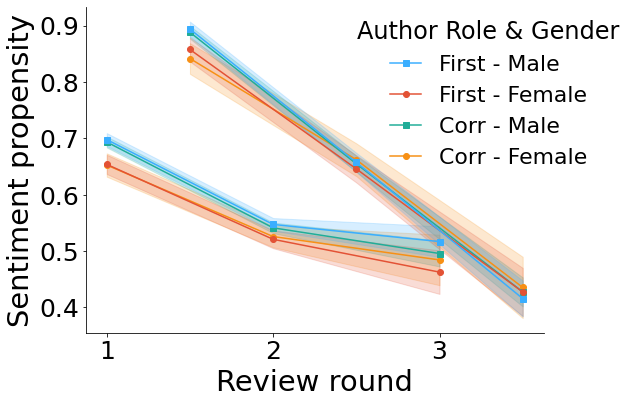

In [6]:
# ==== 绘图 ====
plt.figure(figsize=(8.2, 6))

# Define color and marker mapping
style_mapping = {
    'First Author - Male': {'color': '#3aaeff', 'marker': 's'},             # Turquoise, square
    'First Author - Female': {'color': '#e35235', 'marker': 'o'},          # Pink, circle
    'Corresponding Author - Male': {'color': '#20AD98', 'marker': 's'},    # Teal, square
    'Corresponding Author - Female': {'color': '#f79015', 'marker': 'o'}  # Pink-purple, circle
}

# 创建空的句柄和标签列表
handles = []
labels = []

# Plot reviewer sentiment
for author_group in summary['author_gender'].unique():
    group_data = summary[summary['author_gender'] == author_group]
    style = style_mapping[author_group]
    line, = plt.plot(group_data['Round'], group_data['mean'], marker=style['marker'], color=style['color'])
    plt.fill_between(group_data['Round'],group_data['mean'] - group_data['ci95'],group_data['mean'] + group_data['ci95'],color=style['color'],alpha=0.2)
    # 保存句柄和标签
    handles.append(line)
    labels.append(author_group)

# Plot author response sentiment
for author_group in response_summary['author_gender'].unique():
    group_data = response_summary[response_summary['author_gender'] == author_group]
    style = style_mapping[author_group]
    plt.plot(group_data['Round']+0.5, group_data['mean'], marker=style['marker'], color=style['color']) 
    plt.fill_between(group_data['Round']+0.5,group_data['mean'] - group_data['ci95'],group_data['mean'] + group_data['ci95'],color=style['color'],alpha=0.2)

plt.xlabel('Review round', fontsize=29)
plt.gca().xaxis.set_label_coords(0.5, -0.11)  # (水平位置, 垂直位置)
plt.ylabel('Sentiment propensity', fontsize=29)
plt.xticks([1, 2, 3],fontsize=25)
plt.yticks(fontsize=25)

# 手动创建图例，按照style_mapping的顺序
ordered_handles = []
ordered_labels = []
for author_group in style_mapping.keys():
    if author_group in labels:
        idx = labels.index(author_group)
        ordered_handles.append(handles[idx])
        ordered_labels.append(labels[idx])

ordered_labels=['First - Male','First - Female','Corr - Male','Corr - Female']
plt.legend(ordered_handles, ordered_labels, title='Author Role & Gender', bbox_to_anchor=(0.55, 1.02), loc='upper left',fontsize=22,title_fontsize=24, handlelength=1.4,frameon=False)
plt.grid(False)

# 美化边框
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.tight_layout()
plt.show()

## 2.2.第一作者、通信作者性别与评审轮次

<ipython-input-7-bfa2a5e67a63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_gender['percent'] = grouped_gender.groupby('first_author_gender')['count'].transform(lambda x: x / x.sum())
<ipython-input-7-bfa2a5e67a63>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_gender['percent'] = grouped_gender.groupby('last_author_gender')['count'].transform(lambda x: x / x.sum())


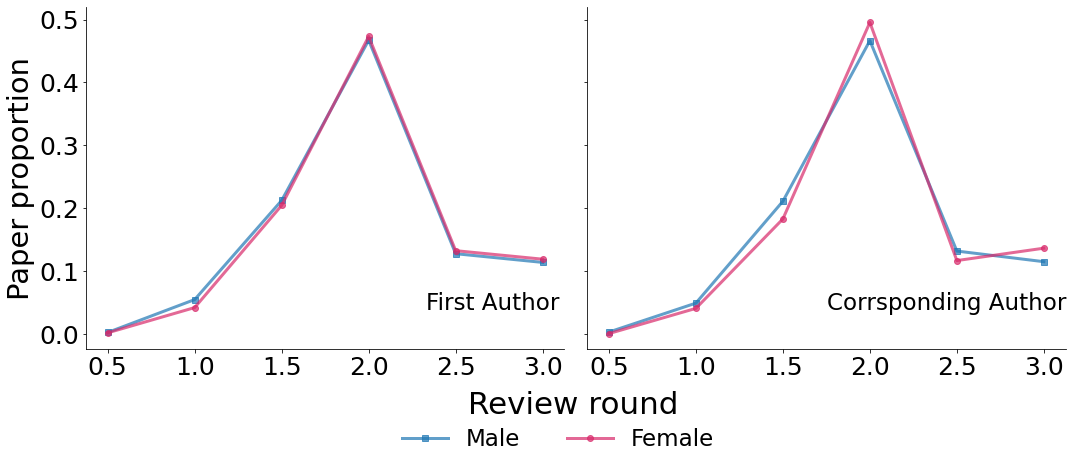

In [7]:
# 创建包含两个子图的大图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ===== 第一个子图：First Author =====
grouped_gender = grouped_gender_first[grouped_gender_first['first_author_gender'].isin(valid_gender)]
# 按性别分别计算 rounds 的总数
grouped_gender['percent'] = grouped_gender.groupby('first_author_gender')['count'].transform(lambda x: x / x.sum())
# 将 round 作为横轴，male 和 female 的百分比分别作为两列
pivot_df = grouped_gender.pivot(index='rounds', columns='first_author_gender', values='percent').fillna(0)
pivot_df = pivot_df[pivot_df.index < 3.5]

# 绘图 - First Author
ax1.plot(pivot_df.index, pivot_df['male'], marker='s', label='Male', linewidth=3, alpha=0.7, color='tab:blue')
ax1.plot(pivot_df.index, pivot_df['female'], marker='o', label='Female', linewidth=3, alpha=0.7, color='#D8296A')

ax1.set_ylabel('Paper proportion', fontsize=29)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.text(0.99, 0.1, str('First Author'), transform=ax1.transAxes,ha='right', va='bottom', fontsize=23, clip_on=False, zorder=10)

ax1.grid(False)
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

# ===== 第二个子图：Last Author =====
grouped_gender = grouped_gender_last[grouped_gender_last['last_author_gender'].isin(valid_gender)]
# 按性别分别计算 rounds 的总数
grouped_gender['percent'] = grouped_gender.groupby('last_author_gender')['count'].transform(lambda x: x / x.sum())
# 将 round 作为横轴，male 和 female 的百分比分别作为两列
pivot_df = grouped_gender.pivot(index='rounds', columns='last_author_gender', values='percent').fillna(0)
pivot_df = pivot_df[pivot_df.index < 3.5]

# 绘图 - Last Author
ax2.plot(pivot_df.index, pivot_df['male'], marker='s', label='Male', linewidth=3, alpha=0.7, color='tab:blue')
ax2.plot(pivot_df.index, pivot_df['female'], marker='o', label='Female', linewidth=3, alpha=0.7, color='#D8296A')

ax2.set_xlabel('Review round', fontsize=31)
ax2.xaxis.set_label_coords(-0.03, -0.12) 
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.text(2.05, 0.1, str('Corrsponding Author'), transform=ax1.transAxes,ha='right', va='bottom', fontsize=23, clip_on=False, zorder=10)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=23, loc='lower center', ncol=2, bbox_to_anchor=(0.52, -0.1),frameon=False)
ax2.grid(False)
ax2.tick_params(axis='x', labelsize=25)
ax2.tick_params(axis='y', labelleft=False)
# 共享y轴刻度
ax2.sharey(ax1)

# 调整子图间距
plt.tight_layout()
plt.show()

# 3.团队性别结构对于评审互动中情感表达的影响

## 3.1.性别多样性

In [ ]:
comment_author_gender=pd.read_csv(".data/comment_author_gender.csv")
response_author_gender=pd.read_csv(".data/response_author_gender.csv")

### 3.1.1.二元性别多样性

In [9]:
author_compound_cols = [f'Round_{i}_response_compound' for i in range(1, 6)]
compound_cols = [f'Round_{i}_compound' for i in range(1, 6)]

# ========== 评审数据 ==========
comment_author_gender_binary = comment_author_gender[comment_author_gender['gender_diversity_binary']>=0].copy()
df_long = comment_author_gender_binary.melt(id_vars=['gender_diversity_binary'],value_vars=compound_cols,var_name='Round',value_name='Compound')
df_long['Round'] = df_long['Round'].str.extract(r'Round_(\d+)').astype(int)
df_long = df_long.dropna(subset=['Compound'])
summary_binary = (df_long.groupby(['gender_diversity_binary', 'Round'])['Compound'].agg(['mean', 'std', 'count']).reset_index())
summary_binary['ci95'] = 1.96 * summary_binary['std'] / np.sqrt(summary_binary['count'])
summary_binary = summary_binary[summary_binary['Round']<=3]


# ========== 作者回复数据 ==========
response_cols = [f'Round_{i}_response_compound' for i in range(1, 6)]
response_author_gender_binary = response_author_gender[response_author_gender['gender_diversity_binary']>=0].copy()
df_response_long = response_author_gender_binary.melt(id_vars=['gender_diversity_binary'],value_vars=response_cols,var_name='Round',value_name='ResponseCompound')
# 提取轮次编号
df_response_long['Round'] = df_response_long['Round'].str.extract(r'Round_(\d+)_response_compound').astype(int)
# 删除 NaN
df_response_long = df_response_long.dropna(subset=['ResponseCompound'])
# 计算每个作者类别在每一轮的均值、标准差、样本数
response_summary_binary = (df_response_long.groupby(['gender_diversity_binary', 'Round'])['ResponseCompound'].agg(['mean', 'std', 'count']).reset_index())
# 添加 95% CI
response_summary_binary['ci95'] = 1.96 * response_summary_binary['std'] / np.sqrt(response_summary_binary['count'])
# 前三轮
response_summary_binary = response_summary_binary[response_summary_binary['Round']<=3]

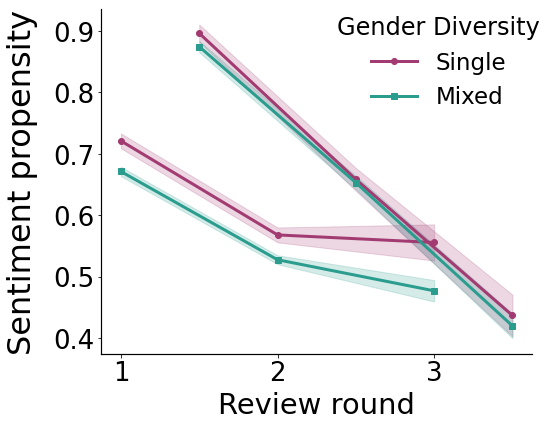

In [10]:
diversity_colors = {0: {'color': '#A23B72', 'marker': 'o', 'label': 'Single'},1: {'color': '#2A9D8F', 'marker': 's', 'label': 'Mixed'}}

# ==== 绘图 ====
plt.figure(figsize=(7.8, 6))

# Plot reviewer sentiment
for author_group in summary_binary['gender_diversity_binary'].unique():
    group_data = summary_binary[summary_binary['gender_diversity_binary'] == author_group]
    style = diversity_colors[author_group]
    plt.plot(group_data['Round'], group_data['mean'], marker=style['marker'], color=style['color'],label=style['label'],linewidth=3.0) 
    plt.fill_between(group_data['Round'],group_data['mean'] - group_data['ci95'],group_data['mean'] + group_data['ci95'],color=style['color'],alpha=0.2)

# Plot author response sentiment
for author_group in response_summary_binary['gender_diversity_binary'].unique():
    group_data = response_summary_binary[response_summary_binary['gender_diversity_binary'] == author_group]
    style = diversity_colors[author_group]
    plt.plot(group_data['Round']+0.5, group_data['mean'], marker=style['marker'], color=style['color'],linewidth=3.0)  
    plt.fill_between(group_data['Round']+0.5,group_data['mean'] - group_data['ci95'],group_data['mean'] + group_data['ci95'],color=style['color'],alpha=0.2)

plt.xticks([1, 2, 3],fontsize=26)
plt.yticks(fontsize=26)
plt.xlabel('Review round', fontsize=29)
plt.gca().xaxis.set_label_coords(0.5, -0.11)  # (水平位置, 垂直位置)
plt.ylabel('Sentiment propensity', fontsize=32,labelpad=15)
plt.legend(title='Gender Diversity', bbox_to_anchor=(0.5, 1.04), loc='upper left',fontsize=23,title_fontsize=24,frameon=False)  # Updated legend title
plt.grid(False)

# 美化边框
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.2)  
ax.spines['left'].set_linewidth(1.2)  

plt.tight_layout()
plt.show()

### 3.1.2.性别多样的学术团队

In [11]:
# ========== 评审数据 ========== 
comment_author_gender_diverse = comment_author_gender_binary[comment_author_gender_binary['gender_diversity_binary']>0].copy()
comment_author_gender_diverse['gender_diverse'] = pd.qcut(comment_author_gender_diverse['gender_diversity_continuous'],q=3,labels=['Low', 'Medium', 'High'])

df_long = comment_author_gender_diverse.melt(id_vars=['gender_diverse'],value_vars=compound_cols,var_name='Round',value_name='Compound')
df_long['Round'] = df_long['Round'].str.extract(r'Round_(\d+)').astype(int)
df_long = df_long.dropna(subset=['Compound'])
summary_diverse = (df_long.groupby(['gender_diverse', 'Round'])['Compound'].agg(['mean', 'std', 'count']).reset_index())
summary_diverse['ci95'] = 1.96 * summary_diverse['std'] / np.sqrt(summary_diverse['count'])
summary_diverse = summary_diverse[summary_diverse['Round']<=3]


# # ========== 作者回复数据 ==========
response_author_gender_diverse = response_author_gender_binary[response_author_gender_binary['gender_diversity_binary']>0].copy()
response_author_gender_diverse['gender_diverse'] = pd.qcut(response_author_gender_diverse['gender_diversity_continuous'],q=3,labels=['Low', 'Medium', 'High'])

df_response_long = response_author_gender_diverse.melt(id_vars=['gender_diverse'],value_vars=response_cols,var_name='Round',value_name='ResponseCompound')
df_response_long['Round'] = df_response_long['Round'].str.extract(r'Round_(\d+)_response_compound').astype(int)
df_response_long = df_response_long.dropna(subset=['ResponseCompound'])
response_summary_diverse = (df_response_long.groupby(['gender_diverse', 'Round'])['ResponseCompound'].agg(['mean', 'std', 'count']).reset_index())
response_summary_diverse['ci95'] = 1.96 * response_summary_diverse['std'] / np.sqrt(response_summary_diverse['count'])
response_summary_diverse = response_summary_diverse[response_summary_diverse['Round']<=3]


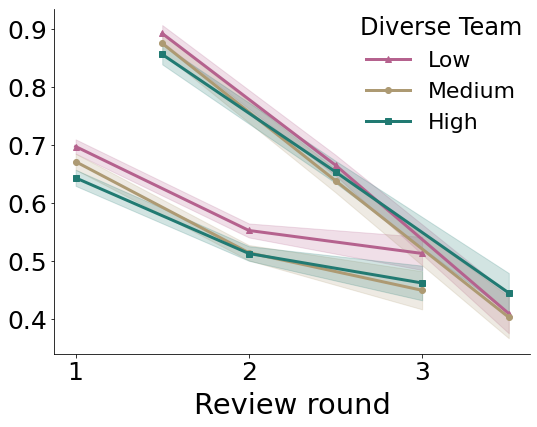

In [12]:
level_style_mapping = {'Low': {'color': '#B5628E','marker': '^','label': 'Low'},'Medium': {'color': '#AD9A73','marker': 'o','label': 'Medium'},'High': {'color': '#217A72','marker': 's','label': 'High'}}

# ==== 绘图 ====
plt.figure(figsize=(7.8, 6))

# Plot reviewer sentiment
for author_group in summary_diverse['gender_diverse'].unique():
    group_data = summary_diverse[summary_diverse['gender_diverse'] == author_group]
    style = level_style_mapping[author_group]
    plt.plot(group_data['Round'], group_data['mean'], marker=style['marker'], color=style['color'],label=style['label'],linewidth=3.0)  # Using the defined label
    plt.fill_between(group_data['Round'],group_data['mean'] - group_data['ci95'],group_data['mean'] + group_data['ci95'],color=style['color'],alpha=0.2)

# Plot author response sentiment
for author_group in response_summary_diverse['gender_diverse'].unique():
    group_data = response_summary_diverse[response_summary_diverse['gender_diverse'] == author_group]
    style = level_style_mapping[author_group]
    plt.plot(group_data['Round']+0.5, group_data['mean'], marker=style['marker'], color=style['color'],linewidth=3.0)  # Append (Response) to label
    plt.fill_between(group_data['Round']+0.5,group_data['mean'] - group_data['ci95'],group_data['mean'] + group_data['ci95'],color=style['color'],alpha=0.2)

plt.xticks([1, 2, 3],fontsize=25)
plt.yticks(fontsize=25)

plt.xlabel('Review round', fontsize=29)
plt.gca().xaxis.set_label_coords(0.5, -0.11)  # (水平位置, 垂直位置)
plt.legend(title='Diverse Team', bbox_to_anchor=(0.6, 1.04), loc='upper left',fontsize=22,title_fontsize=24,frameon=False)
plt.grid(False)

# 美化边框
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 3.2.性别领导力

In [13]:
# ========== 评审数据 ==========
comment_gender_leadership = comment_author_gender.loc[(comment_author_gender['first_author_gender'].isin(valid_gender))&(comment_author_gender['last_author_gender'].isin(valid_gender))]
comment_gender_leadership['gender_leadership']=comment_gender_leadership.apply(lambda row: row['first_author_gender'].capitalize() + "-" + row['last_author_gender'].capitalize(),axis=1)
comment_gender_leadership = comment_gender_leadership.sort_values(by='gender_leadership',ascending=False)

# 将宽表转为长表
df_long = comment_gender_leadership.melt(id_vars=['gender_leadership'],value_vars=compound_cols,var_name='Round',value_name='Compound')
# 提取轮次编号
df_long['Round'] = df_long['Round'].str.extract(r'Round_(\d+)').astype(int)
# 删除 NaN
df_long = df_long.dropna(subset=['Compound'])
# 计算每个作者类别在每一轮的均值、标准差、样本数
summary_leadership = (df_long.groupby(['gender_leadership', 'Round'])['Compound'].agg(['mean', 'std', 'count']).reset_index())
# 添加 95% CI
summary_leadership['ci95'] = 1.96 * summary_leadership['std'] / np.sqrt(summary_leadership['count'])
summary_leadership = summary_leadership[summary_leadership['Round']<=3]

# ========== 作者回复数据 ==========
response_gender_leadership = response_author_gender.loc[(response_author_gender['first_author_gender'].isin(valid_gender))&(response_author_gender['last_author_gender'].isin(valid_gender))]
response_gender_leadership['gender_leadership']=response_gender_leadership.apply(lambda row: row['first_author_gender'].capitalize() + "-" + row['last_author_gender'].capitalize(),axis=1)
response_gender_leadership = response_gender_leadership.sort_values(by='gender_leadership',ascending=False)

# 将宽表转为长表
df_long = response_gender_leadership.melt(id_vars=['gender_leadership'],value_vars=response_cols,var_name='Round',value_name='Compound')
# 提取轮次编号
df_long['Round'] = df_long['Round'].str.extract(r'Round_(\d+)').astype(int)
# 删除 NaN
df_long = df_long.dropna(subset=['Compound'])
# 计算每个作者类别在每一轮的均值、标准差、样本数
response_summary_leadership = (df_long.groupby(['gender_leadership', 'Round'])['Compound'].agg(['mean', 'std', 'count']).reset_index())
# 添加 95% CI
response_summary_leadership['ci95'] = 1.96 * response_summary_leadership['std'] / np.sqrt(response_summary_leadership['count'])
response_summary_leadership = response_summary_leadership[response_summary_leadership['Round']<=3]

<ipython-input-13-13613c92cd45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_gender_leadership['gender_leadership']=comment_gender_leadership.apply(lambda row: row['first_author_gender'].capitalize() + "-" + row['last_author_gender'].capitalize(),axis=1)
<ipython-input-13-13613c92cd45>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  response_gender_leadership['gender_leadership']=response_gender_leadership.apply(lambda row: row['first_author_gender'].capitalize() + "-" + row['last_author_gende

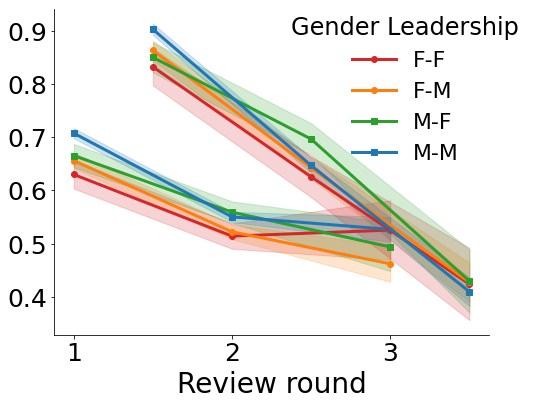

In [14]:
# ==== 绘图 ====
plt.figure(figsize=(7.8, 6))

# Define style mapping
gender_leadership_style_mapping = {
    'Female-Female': {'color': '#d62728', 'marker': 'o'},  # Red circle
    'Female-Male': {'color': '#ff7f0e', 'marker': 'o'},   # Orange circle
    'Male-Female': {'color': '#2ca02c', 'marker': 's'},    # Green square
    'Male-Male': {'color': '#1f77b4', 'marker': 's'}      # Blue square
}

# Plot data
for author_group in summary_leadership['gender_leadership'].unique():
    group_data = summary_leadership[summary_leadership['gender_leadership'] == author_group]
    style = gender_leadership_style_mapping[author_group]
    plt.plot(group_data['Round'], group_data['mean'],marker=style['marker'],color=style['color'],label=author_group,linewidth=3.0)
    plt.fill_between(group_data['Round'],group_data['mean'] - group_data['ci95'],group_data['mean'] + group_data['ci95'],color=style['color'],alpha=0.2)

# Add response data if needed (using same style mapping)
for author_group in response_summary_leadership['gender_leadership'].unique():
    group_data = response_summary_leadership[response_summary_leadership['gender_leadership'] == author_group]
    style = gender_leadership_style_mapping[author_group]
    plt.plot(group_data['Round']+0.5, group_data['mean'],marker=style['marker'],color=style['color'],linewidth=3.0)
    plt.fill_between(group_data['Round']+0.5,group_data['mean'] - group_data['ci95'],group_data['mean'] + group_data['ci95'],color=style['color'],alpha=0.2)

plt.xticks([1, 2, 3],fontsize=25)
plt.yticks(fontsize=25)

plt.xlabel('Review round', fontsize=28)
plt.gca().xaxis.set_label_coords(0.5, -0.11)  # (水平位置, 垂直位置)


handles, labels = plt.gca().get_legend_handles_labels()
# 修改标签文本
new_labels = ['F-F', 'F-M', 'M-F', 'M-M']

plt.legend(handles=handles, labels=new_labels,title='Gender Leadership', bbox_to_anchor=(0.5, 1.04), loc='upper left',fontsize=22,title_fontsize=24,frameon=False)

plt.grid(False)

# Formatting
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# 4.潜在影响

## 4.1.对于评审意见情感倾向

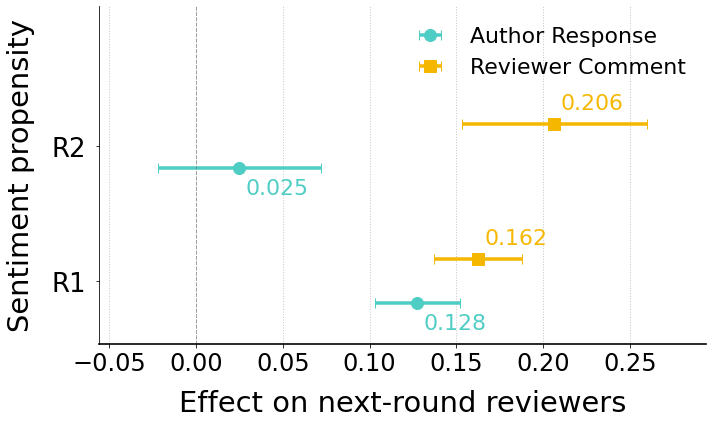

In [15]:
coefs = np.array([0.1275495, 0.0250434])
ci_lowers = np.array([0.1030228, -0.0218716])
ci_uppers = np.array([0.1520763, 0.0719583])

reviewer_coefs = np.array([0.1624404, 0.2064121])
reviewer_ci_lowers = np.array([0.137234, 0.1531833])
reviewer_ci_uppers = np.array([0.1876468, 0.2596409])

# 标签
round_labels = ["R1", "R2"]
group_labels = ["Author Response", "Reviewer Comment"]

# 计算误差棒
author_lower_err = coefs - ci_lowers
author_upper_err = ci_uppers - coefs
author_xerr = np.vstack([author_lower_err, author_upper_err])

reviewer_lower_err = reviewer_coefs - reviewer_ci_lowers
reviewer_upper_err = reviewer_ci_uppers - reviewer_coefs
reviewer_xerr = np.vstack([reviewer_lower_err, reviewer_upper_err])

# 设置y轴位置
y_pos_author = np.arange(len(coefs))-0.3
y_pos_reviewer = np.arange(len(reviewer_coefs)) + 0.03  # 稍微偏移避免重叠

# 绘图
fig, ax = plt.subplots(figsize=(10, 6))

character_colors={"author": "#4ECDC4","reviewer": "#F5B700"}
# 绘制作者数据（蓝色）
ax.errorbar(coefs, y_pos_author, xerr=author_xerr, fmt='o', capsize=5, linewidth=3.5, color=character_colors['author'], label='Author Response', markersize=12)

# 绘制审稿人数据（橙色）
ax.errorbar(reviewer_coefs, y_pos_reviewer, xerr=reviewer_xerr, fmt='s', capsize=5, linewidth=3.5, color=character_colors['reviewer'], label='Reviewer Comment', markersize=12)

# 参考线
ax.axvline(0, linestyle='--', linewidth=1, color='gray', alpha=0.7)

# 坐标轴设置
ax.tick_params(axis='x', labelsize=24)
ax.set_yticks((y_pos_author + y_pos_reviewer) / 2)  # 设置y轴刻度在两组中间
ax.set_yticklabels(round_labels, fontsize=26)
ax.tick_params(axis='y', which='major', pad=10)
ax.set_xlabel("Effect on next-round reviewers", fontsize=29, labelpad=14)
ax.set_ylabel("Sentiment propensity", fontsize=29,labelpad=16)

# 设置坐标轴范围
all_ci_lowers = np.concatenate([ci_lowers, reviewer_ci_lowers])
all_ci_uppers = np.concatenate([ci_uppers, reviewer_ci_uppers])
x_min, x_max = float(np.min(all_ci_lowers)), float(np.max(all_ci_uppers))
x_range = x_max - x_min
pad_x = 0.12 * x_range if x_range > 0 else 0.02
ax.set_xlim(x_min - pad_x, x_max + pad_x)

# y轴范围
ax.set_ylim(-0.6, len(coefs) - 0.1)

# 网格和边框
ax.grid(axis='x', linestyle=':', linewidth=1, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.64)  # 默认值通常为0.8-1.0

# 添加数值标注
for y, x in zip(y_pos_author, coefs):
    ax.annotate(f"{x:.3f}", (x, y-0.15), xytext=(6, 0), textcoords="offset points", va="center", fontsize=22, color=character_colors['author'])

for y, x in zip(y_pos_reviewer, reviewer_coefs):
    ax.annotate(f"{x:.3f}", (x, y+0.15), xytext=(6, 0), textcoords="offset points", va="center", fontsize=22, color=character_colors['reviewer'])

# 添加图例
ax.legend(loc='upper right', fontsize=22, frameon=False)

plt.tight_layout()

plt.show()

## 4.2.对于评审轮次

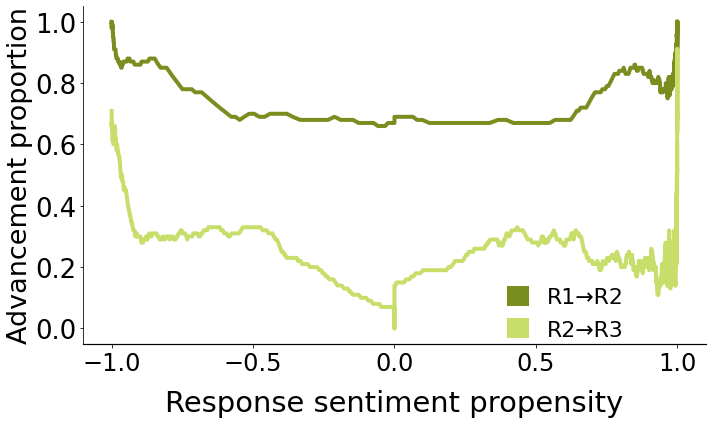

In [16]:
colors = ['#7A8E20','#C8DE6A'] 

def rolling_curve(df, response_col, next_col, window=400, min_periods=10):
    d = df[[response_col, next_col]].dropna().sort_values(response_col)
    if len(d) == 0: 
        return None
    x = d[response_col].rolling(20, min_periods=15, center=True).mean()
    y = d[next_col].rolling(window, min_periods=min_periods, center=True).mean()
    return (x.values, y.values)

def plot_rolling(ax, curve1, curve2):
   
    if curve1 is not None:
        x1, y1 = curve1
        ax.plot(x1, y1, color=colors[0], lw=4, label='R1→R2')
    
    if curve2 is not None:
        x2, y2 = curve2
        ax.plot(x2, y2, color=colors[1], lw=4, ls='-', label='R2→R3')
    
    ax.set_ylabel('Advancement proportion', fontsize=27,labelpad=2)
    ax.set_xlabel('Response sentiment propensity', fontsize=29, labelpad=14)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=26)
    ax.spines['bottom'].set_linewidth(1.2)  # 默认值通常为0.8-1.0
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# 计算滚动曲线
c1 = rolling_curve(gender_df2, 'round_1_response', 'has_round_2', window=100, min_periods=10)
c2 = rolling_curve(gender_df2, 'round_2_response', 'has_round_3', window=100, min_periods=10)

# 创建单个图形
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# 绘制数据
plot_rolling(ax, c1, c2)

# 创建自定义图例句柄（正方形色块）
legend_elements = [Patch(facecolor=colors[0], label='R1→R2'),Patch(facecolor=colors[1], label='R2→R3')]

ax.legend(handles=legend_elements, bbox_to_anchor=(0.9, 0.23), fontsize=22, frameon=False, handlelength=1, handleheight=1)

plt.tight_layout()
plt.show()

## 4.3.性别×情感倾向 交互项

### 4.3.1.个体学者性别

In [17]:
# ---------- round 1 ----------
x_r1 = [0.11, 0.1841667, 0.2583333, 0.3325, 0.4066667, 0.4808333, 0.555, 0.6291667, 0.7033333, 0.7775, 0.8516667, 0.9258333, 1.0]

y_female_r1  = [0.3729216, 0.4447677, 0.5191829, 0.5930606, 0.6633207,0.727399, 0.7835895, 0.8311492, 0.8701835, 0.9014009,0.9258426, 0.9446567, 0.9589465]
lo_female_r1 = [-0.1329377, -0.0451452, 0.0678246, 0.1986687, 0.3371203,0.472297, 0.5951149, 0.6998091, 0.7841828, 0.8488529,0.8960282, 0.928215, 0.9476494]
hi_female_r1 = [0.878781, 0.9346805, 0.9705413, 0.9874525, 0.989521,0.9825011, 0.9720642, 0.9624893, 0.9561841, 0.9539489,0.9556571, 0.9610984, 0.9702436]

# Male (last_author_gender = 1)
y_male_r1  = [0.3757218, 0.4442701, 0.5151737, 0.5857441, 0.6532919,0.7155184, 0.7708057, 0.8183323, 0.8580152, 0.8903336,0.9161132, 0.936332, 0.9519759]
lo_male_r1 = [0.082859, 0.161302, 0.254109, 0.3564343, 0.4619502,0.5640965, 0.6573574, 0.738103, 0.8047887, 0.8576086,0.8978463, 0.9270628, 0.9461969]
hi_male_r1 = [0.6685845, 0.9346805, 0.7762385, 0.8150538, 0.8446336,0.8669404, 0.8842539, 0.8985617, 0.9112418, 0.9230585,0.9343801, 0.9456011, 0.9577548]

df_r1 = pd.DataFrame({"round":   ["round1"] * (2 * len(x_r1)),"x":       x_r1 * 2,"gender":  ["female"] * len(x_r1) + ["male"] * len(x_r1),"y":       y_female_r1 + y_male_r1,"ci_low":  lo_female_r1 + lo_male_r1,"ci_high": hi_female_r1 + hi_male_r1,})


# ---------- round 2 ----------
x_r2 = [0.0083, 0.0909417, 0.1735833, 0.256225, 0.3388667,0.4215083, 0.50415, 0.5867917, 0.6694333, 0.752075,  0.8347167, 0.9173583, 1.0]

y_female_r2  = [0.126289, 0.1396249, 0.1541005, 0.1697589, 0.1866338,0.2047473, 0.2241081, 0.2447095, 0.2665272, 0.289518,0.3136188, 0.3387462, 0.3647964]
lo_female_r2 = [-0.0561533, -0.0418072, -0.0241703, -0.0029496, 0.0221137, 0.0512263, 0.0845209, 0.1220257, 0.1636121, 0.2088701,0.2566638, 0.3028215, 0.3315056]
hi_female_r2 = [0.3087314, 0.3210569, 0.3323713, 0.3424675, 0.3511539,0.3582682, 0.3636953, 0.3673934, 0.3694424, 0.3701659,0.3705739, 0.3746709, 0.3980871]

# Male (last_author_gender = 1)
y_male_r2  = [0.0991083, 0.1127608, 0.1280017, 0.1449371, 0.1636599,0.184244, 0.2067378, 0.2311585, 0.2574851, 0.2856542,0.3155555, 0.3470304, 0.3798722]
lo_male_r2 = [0.0172043, 0.0289257, 0.0433019, 0.0606657, 0.0813348,0.1055915, 0.1336581, 0.1656668, 0.2016198, 0.2413172,0.2841453, 0.3279461, 0.3632965]
hi_male_r2 = [0.1810123, 0.1965959, 0.2127015, 0.2292084, 0.2459849,0.2628964, 0.2798176, 0.2966501, 0.3133504, 0.3299912,0.3469658, 0.3661147, 0.3964479]


df_r2 = pd.DataFrame({"round":   ["round2"] * (2 * len(x_r2)),"x":  x_r2 * 2,"gender":  ["female"] * len(x_r2) + ["male"] * len(x_r2),"y": y_female_r2 + y_male_r2,"ci_low":  lo_female_r2 + lo_male_r2,"ci_high": hi_female_r2 + hi_male_r2,})

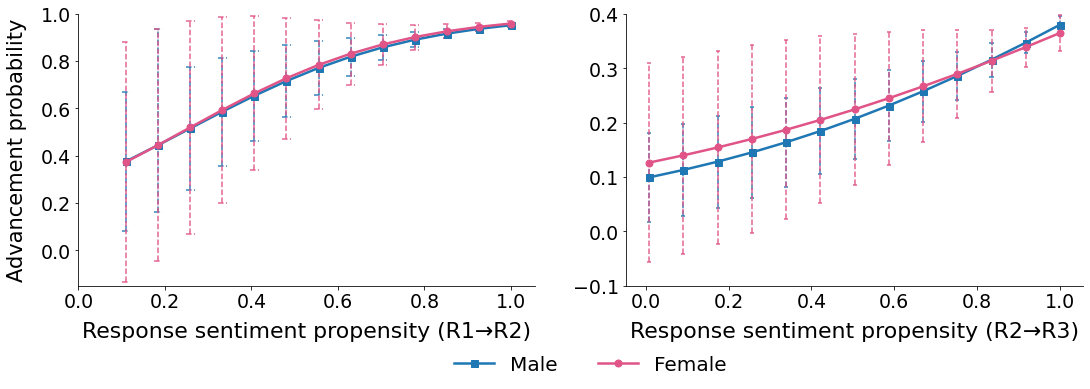

In [18]:
# 定义颜色和标记
markers = {"male": "s", "female": "o"} 
gender_colors={"male": "#1f77b4", "female": "#E05487"}

# 创建包含两个子图的大图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# ===== 第一个子图：R1 =====
for g in ["male", "female"]:  # 控制图例顺序
    sub = df_r1[df_r1["gender"] == g].sort_values("x")
    ax1.plot(sub["x"], sub["y"], marker=markers[g], ms=7, lw=2.5, linestyle="-", color=gender_colors[g], label=g.capitalize(), zorder=3)
    # 计算误差值（y值到上下界的距离）
    y_err_lower = sub["y"] - sub["ci_low"]
    y_err_upper = sub["ci_high"] - sub["y"]
    y_err = [y_err_lower.values, y_err_upper.values]
    # 手动绘制误差线
    for i, (x, y, y_low, y_high) in enumerate(zip(sub["x"], sub["y"], sub["ci_low"], sub["ci_high"])):
        # 绘制垂直的误差棒线（虚线）
        ax1.plot([x, x], [y_low, y_high], linestyle="dashed", color=gender_colors[g], alpha=0.9, linewidth=1.5, zorder=2)
        # 绘制误差棒的上端帽
        ax1.plot([x-0.01, x+0.01], [y_high, y_high], linestyle="dashed", color=gender_colors[g], alpha=0.9, linewidth=1.5, zorder=2)
        # 绘制误差棒的下端帽
        ax1.plot([x-0.01, x+0.01], [y_low, y_low], linestyle="dashed", color=gender_colors[g], alpha=0.9, linewidth=1.5, zorder=2)


ax1.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_xticklabels([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.tick_params(axis='x', labelsize=19)
ax1.tick_params(axis='y', labelsize=19)

ax1.set_ylabel("Advancement probability", fontsize=21, labelpad=14)
ax1.set_xlabel("Response sentiment propensity (R1→R2)", fontsize=22)
ax1.xaxis.set_label_coords(0.5, -0.13)

ax1.set_ylim(-0.15, 1.00) 
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

# ===== 第二个子图：R2 =====
for g in ["male", "female"]:  # 控制图例顺序
    sub = df_r2[df_r2["gender"] == g].sort_values("x")
    ax2.plot(sub["x"], sub["y"], marker=markers[g], ms=7, lw=2.5, linestyle="-", color=gender_colors[g], label=g.capitalize(), zorder=3)
    # 计算误差值（y值到上下界的距离）
    y_err_lower = sub["y"] - sub["ci_low"]
    y_err_upper = sub["ci_high"] - sub["y"]
    y_err = [y_err_lower.values, y_err_upper.values]
    
    for i, (x, y, y_low, y_high) in enumerate(zip(sub["x"], sub["y"], sub["ci_low"], sub["ci_high"])):
        ax2.plot([x, x], [y_low, y_high], linestyle="dashed", color=gender_colors[g], alpha=0.9, linewidth=1.5, zorder=2)
        ax2.plot([x-0.005, x+0.005], [y_high, y_high], linestyle="dashed", color=gender_colors[g], alpha=0.9, linewidth=1.5, zorder=2)
        ax2.plot([x-0.005, x+0.005], [y_low, y_low], linestyle="dashed", color=gender_colors[g], alpha=0.9, linewidth=1.5, zorder=2)

ax2.tick_params(axis='x', labelsize=19)
ax2.tick_params(axis='y', labelsize=19)

ax2.set_xlabel("Response sentiment propensity (R2→R3)", fontsize=22)
ax2.xaxis.set_label_coords(0.5, -0.13)

ax2.set_ylim(-0.1, 0.4) 
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=20, loc='lower center', ncol=2, bbox_to_anchor=(0.52, -0.17),frameon=False)

# 调整子图间距
# plt.tight_layout()
plt.show()

### 4.3.2.团队性别结构

In [19]:
# ---------- round 1 ----------
x = [0.11, 0.1841667, 0.2583333, 0.3325, 0.4066667, 0.4808333, 0.555, 0.6291667, 0.7033333, 0.7775, 0.8516667, 0.9258333, 1.0]

# group=0 (clean_gender_diversity_binary=0)
y0  = [0.1575663, 0.2149276, 0.285647, 0.3683959, 0.4596083,0.5537815, 0.6445997, 0.7264915, 0.7958748, 0.8515472,0.8942519, 0.9258656, 0.9486443]
lo0 = [-0.2036142, -0.2031659, -0.1716992, -0.099752, 0.0153238,0.1659077, 0.3348546, 0.5011348, 0.6471927, 0.7635306,0.8486986, 0.906018, 0.9385559]
hi0 = [0.5187468, 0.6330211, 0.7429931, 0.8365438, 0.9038928,0.9416553, 0.9543449, 0.9518481, 0.944557, 0.9395637,0.9398052, 0.9457132, 0.9587327]

# group=1 (clean_gender_diversity_binary=1)
y1  = [0.4305309, 0.498056, 0.56579, 0.6313514, 0.6926209,0.7479967, 0.7965256, 0.8378964, 0.8723284, 0.9004072,0.9229208, 0.9407243, 0.9546471]
lo1 = [0.1052278, 0.1936984, 0.2932873, 0.3982626, 0.5023611,0.5999379, 0.6868425, 0.7607877, 0.8212216, 0.8688742,0.9051728, 0.9315653, 0.9487812]
hi1 = [0.755834, 0.8024135, 0.8382927, 0.8644403, 0.8828808,0.8960555, 0.9062087, 0.9150052, 0.9234352, 0.9319403,0.9406688, 0.9498832, 0.9605131]

# 组装长表
df_gender_binary_1 = pd.DataFrame({"x": x + x,"gender_diversity_binary": [0]*len(x) + [1]*len(x),"y":  y0 + y1,"ci_low": lo0 + lo1,"ci_high": hi0 + hi1,})

x = [0.0083, 0.0909417, 0.1735833, 0.256225, 0.3388667, 0.4215083, 0.50415, 0.5867917, 0.6694333, 0.752075, 0.8347167, 0.9173583, 1.0]

# group=0 (clean_gender_diversity_binary=0)
y0  = [0.0542298, 0.0650061, 0.0777272, 0.0926643, 0.1100954,0.1302924, 0.1535046, 0.1799374, 0.2097274, 0.2429169,0.2794287, 0.319046, 0.3614022]
lo0 = [-0.0454574, -0.0429393, -0.0375872, -0.0285428, -0.0148334,0.0045919, 0.0307996, 0.0647754, 0.1072855, 0.1586694,0.2184065, 0.2831323, 0.3324884]
hi0 = [0.1539171, 0.1729514, 0.1930416, 0.2138714, 0.2350241,0.2559929, 0.2762096, 0.2950993, 0.3121693, 0.3271645,0.3404508, 0.3549597, 0.390316]

# group=1 (clean_gender_diversity_binary=1)
y1  = [0.1422607, 0.1562762, 0.1713776, 0.1875933, 0.204942,0.2234312, 0.2430552, 0.2637938, 0.2856111, 0.3084545,0.3322545, 0.3569244, 0.3823612]
lo1 = [0.0444441, 0.0597072, 0.0771737, 0.0969759, 0.1192205,0.1439795, 0.1712795, 0.2010875, 0.2332852, 0.267607,0.3034164, 0.3385781, 0.3654874]
hi1 = [0.2400773, 0.2528452, 0.2655815, 0.2782106, 0.2906635,0.302883, 0.3148309, 0.3265001, 0.3379369, 0.349302,0.3610926, 0.3752707, 0.399235]

df_gender_binary_2 = pd.DataFrame({"x": x + x,"gender_diversity_binary": [0]*len(x) + [1]*len(x),"y":  y0 + y1,"ci_low": lo0 + lo1,"ci_high": hi0 + hi1,})

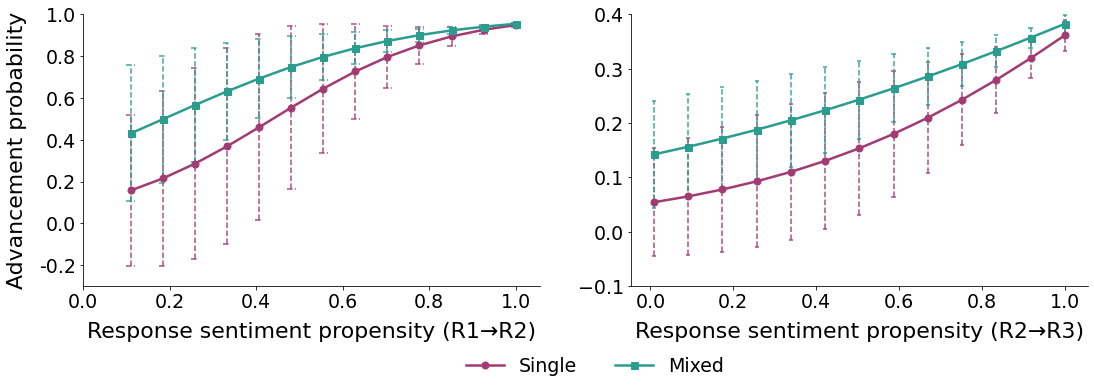

In [20]:
# 创建包含两个子图的大图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# ===== 第一个子图：R1 =====
for g in [0, 1]:  # 使用数字键
    sub = df_gender_binary_1[df_gender_binary_1["gender_diversity_binary"] == g].sort_values("x")
    ax1.plot(sub["x"], sub["y"], marker=diversity_colors[g]['marker'], ms=7, lw=2.5, linestyle="-", color=diversity_colors[g]['color'], label=diversity_colors[g]['label'], zorder=3)
    # 手动绘制误差线
    for i, (x, y, y_low, y_high) in enumerate(zip(sub["x"], sub["y"], sub["ci_low"], sub["ci_high"])):
        # 绘制垂直的误差棒线（虚线）
        ax1.plot([x, x], [y_low, y_high], linestyle="dashed", color=diversity_colors[g]['color'], alpha=0.9, linewidth=1.5, zorder=2)
        # 绘制误差棒的上端帽
        ax1.plot([x-0.01, x+0.01], [y_high, y_high], linestyle="dashed", color=diversity_colors[g]['color'], alpha=0.9, linewidth=1.5, zorder=2)
        # 绘制误差棒的下端帽
        ax1.plot([x-0.01, x+0.01], [y_low, y_low], linestyle="dashed", color=diversity_colors[g]['color'], alpha=0.9, linewidth=1.5, zorder=2)

ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_xticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax1.set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax1.set_yticklabels(['-0.4','-0.2','0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax1.tick_params(axis='x', labelsize=19)
ax1.tick_params(axis='y', labelsize=19)
ax1.xaxis.set_label_coords(0.5, -0.09)

ax1.set_ylabel("Advancement probability", fontsize=22, labelpad=12)
ax1.set_xlabel("Response sentiment propensity (R1→R2)", fontsize=22)
ax1.xaxis.set_label_coords(0.5, -0.13)

ax1.set_ylim(-0.3, 1) 
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

# ===== 第二个子图：R2 =====
for g in [0, 1]:  # 使用数字键
    sub = df_gender_binary_2[df_gender_binary_2["gender_diversity_binary"] == g].sort_values("x")
    ax2.plot(sub["x"], sub["y"], marker=diversity_colors[g]['marker'], ms=7, lw=2.5, linestyle="-", color=diversity_colors[g]['color'], label=diversity_colors[g]['label'], zorder=3)
    # 手动绘制误差线
    for i, (x, y, y_low, y_high) in enumerate(zip(sub["x"], sub["y"], sub["ci_low"], sub["ci_high"])):
        ax2.plot([x, x], [y_low, y_high], linestyle="dashed", color=diversity_colors[g]['color'], alpha=0.9, linewidth=1.5, zorder=2)
        ax2.plot([x-0.005, x+0.005], [y_high, y_high], linestyle="dashed", color=diversity_colors[g]['color'], alpha=0.9, linewidth=1.5, zorder=2)
        ax2.plot([x-0.005, x+0.005], [y_low, y_low], linestyle="dashed", color=diversity_colors[g]['color'], alpha=0.9, linewidth=1.5, zorder=2)

ax2.tick_params(axis='x', labelsize=19)
ax2.tick_params(axis='y', labelsize=19)

ax2.set_xlabel("Response sentiment propensity (R2→R3)", fontsize=22)
ax2.xaxis.set_label_coords(0.5, -0.13)

ax2.set_ylim(-0.1, 0.4) 
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=19, loc='lower center', ncol=2, bbox_to_anchor=(0.52, -0.17),frameon=False)

# 调整子图间距
# plt.tight_layout()
plt.show()
